In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pymaster as nmt
import healpy as hp
import pysm3

from fgbuster import (CMB, Dust, Dustmom, Synchrotron, 
                      basic_comp_sep, 
                      get_observation, get_instrument)

from fgbuster.visualization import corner_norm

nside = 32
instrument = get_instrument('LiteBIRD')
sky = pysm3.Sky(nside=nside, preset_strings=['c1','d1'])
freq_maps = get_observation(instrument, sky, nside=nside)
fsky=0.7
cut = {0.5:53,0.6:80,0.7:121}
mask0 = hp.read_map(Pr+"Moments/masks/mask_nside512_fsky%spc_P353_smooth10deg_cut%smuK.fits"%(int(fsky*100),cut[fsky]))
mask0 = hp.ud_grade(mask0,nside_out=nside)
#mask = nmt.mask_apodization(mask0, 10, apotype='C2')
b = nmt.bins.NmtBin(nside=nside,lmax=2*nside+1,nlb=5)
ell = b.get_effective_ells()

#mask=mask0
mask = np.ones((hp.nside2npix(nside)))

freq_maps = freq_maps*mask

components = [CMB(), Dust(353.)]

result = basic_comp_sep(components, instrument, freq_maps)
components = [CMB(), Dustmom(353.,beta_d=result.x[0],temp=result.x[1],torder=0,border=2)]
resultmom = basic_comp_sep(components, instrument, freq_maps)

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from fgbuster import get_instrument, get_sky, get_observation  # Predefined instrumental and sky-creation configurations
import fgbuster.separation_recipes as sr

# Imports needed for component separation
from fgbuster import (CMB, Dust, Dustmom, Synchrotron,  # sky-fitting model
                      MixingMatrix)  # separation routine
components = [CMB(), Dust(353.)]
nsides = [4, 4]
result_multi = sr.multi_res_comp_sep(components, instrument, freq_maps[:, 1:], nsides=nsides)#, method='L-BFGS-B', options=dict(disp=True))


[]

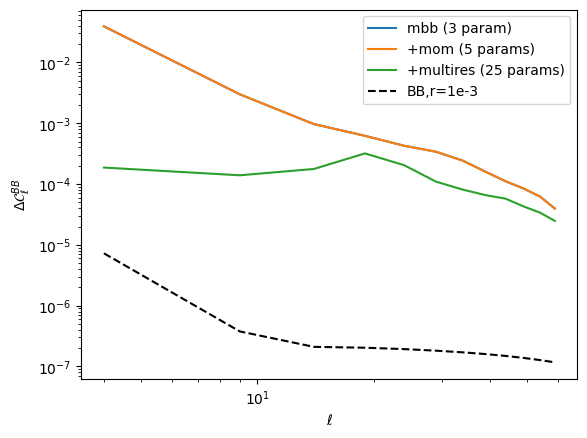

In [32]:
incmb = sky.components[0].map[:].value
cmb = np.array([np.ones((result.s[0, 0].shape)),result.s[0, 1],result.s[0, 2]])
fa1 = nmt.NmtField(mask,(cmb[1:]-incmb[1:])*mask,purify_e=False, purify_b=True)
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(fa1, fa1, b)
cl = compute_master(fa1,fa1,wsp)        
clBB=cl[3]

cmbmom = np.array([np.ones((resultmom.s[0, 0].shape)),resultmom.s[0, 1],resultmom.s[0, 2]])
fa1 = nmt.NmtField(mask,(cmbmom[1:]-incmb[1:])*mask,purify_e=True, purify_b=True)
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(fa1, fa1, b)
clmom = compute_master(fa1,fa1,wsp)        
clBBmom=clmom[3]

cmbmr = np.array([np.ones((result_multi.s[0, 0].shape)),result_multi.s[0,0],result_multi.s[0, 1]])
fa1 = nmt.NmtField(mask,(cmbmr[1:]-incmb[1:])*mask,purify_e=True, purify_b=True)
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(fa1, fa1, b)
clmr = compute_master(fa1,fa1,wsp)        
clBBmr=clmr[3]

DL_tens = b.bin_cell(np.load(Pr+"/Moments/CLsimus/DLtensor_CAMBparamPlanck2018_r=1.npy")[2,0:2*nside+2])

plt.plot(ell,clBB,label='mbb (3 param)')
plt.plot(ell,clBBmom,label='+mom (5 params)')
plt.plot(ell,clBBmr,label='+multires (25 params)')
plt.plot(ell,1e-3*2*np.pi*DL_tens/(ell*(ell+1)),label='BB,r=1e-3',c='k',linestyle='--')
plt.ylabel("$\Delta \mathcal{C}_\ell^{BB}$")
plt.xlabel("$\ell$")
plt.legend()
plt.loglog()

[]

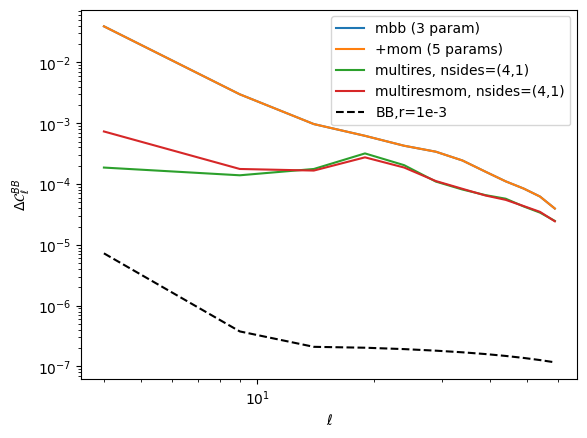

In [33]:
components = [CMB(), Dustmom(353.,beta_d=result.x[0],temp=result.x[1],border=2,torder=0)]
nsides = [4,4]
result_multi_mom = sr.multi_res_comp_sep(components, instrument, freq_maps[:, 1:], nsides=nsides)#, method='L-BFGS-B', options=dict(disp=True))
cmbmr = np.array([np.ones((result_multi_mom.s[0, 0].shape)),result_multi_mom.s[0,0],result_multi_mom.s[0, 1]])
fa1 = nmt.NmtField(mask,(cmbmr[1:]-incmb[1:])*mask,purify_e=True, purify_b=True)
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(fa1, fa1, b)
clmrmom = compute_master(fa1,fa1,wsp)        
clBBmrmom=clmrmom[3]


plt.plot(ell,clBB,label='mbb (3 param)')
plt.plot(ell,clBBmom,label='+mom (5 params)')
plt.plot(ell,clBBmr,label='multires, nsides=(4,1)')
plt.plot(ell,clBBmrmom,label='multiresmom, nsides=(4,1)')
plt.plot(ell,1e-3*2*np.pi*DL_tens/(ell*(ell+1)),label='BB,r=1e-3',c='k',linestyle='--')
plt.ylabel("$\Delta \mathcal{C}_\ell^{BB}$")
plt.xlabel("$\ell$")
plt.legend()
plt.loglog()

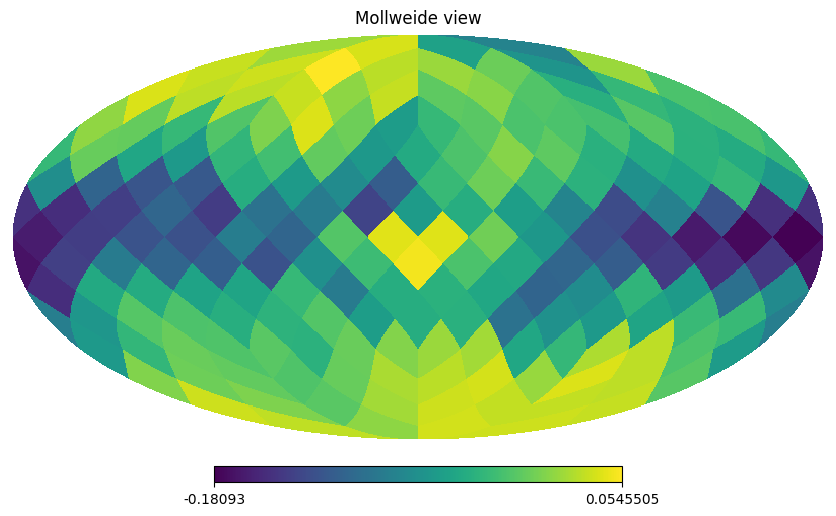

In [34]:
hp.mollview(result_multi_mom.x[1])